<p style="font-size:32px;text-align:center"> <b>Intent Classification and Sentiment Analysis </b> </p>

### Problem statement:
Given a sentence, we have to predict the intent of that sentence and its sentiment.

### Data Overview
Data Taken from  https://github.com/clinc/oos-eval


### Business objectives and constraints:  
- low-latency requirement
- Probability of prediction is useful to recommend highest probability class of intents and sentiments

# 1. Importing Libraries

In [5]:
import numpy as np
import json
import pickle
import pandas as pd
from tensorflow.python.keras.models import load_model
import pickle
import seaborn as sns
import json
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-08-31 16:37:32,876 loading file C:\Users\snake\.flair\models\sentiment-en-mix-distillbert_4.pt


# 2. Loading Dataset



* JSON structure:

    {
        "train": List of training samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
        "val":  List of validation samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
         "test":  List of testing samples with each sample representing a tuple: (query,class)
                [
                     ["query / sentence","intent_class"],
                     ["query / sentence","intent_class"],
                ],
          ...further similar 3 sets for out-of-scope queries for advance classification.
    }

In [2]:
# Loading json data
with open('data_full.json') as file:
    data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])

In [3]:
val

array([['set a warning for when my bank account starts running low',
        'oos'],
       ['a show on broadway', 'oos'],
       ['who has the best record in the nfl', 'oos'],
       ...,
       ["do you know why my card was declined at target i can't figure out why",
        'card_declined'],
       ["i can't figure out why my card was declined at target",
        'card_declined'],
       ["i was just at target and they declined my card and i can't understand why",
        'card_declined']], dtype='<U114')

In [4]:
train

array([['how much is an overdraft fee for bank', 'oos'],
       ['why are exponents preformed before multiplication in the order of operations',
        'oos'],
       ['what size wipers does this car take', 'oos'],
       ...,
       ['how come my card was not accepted yesterday', 'card_declined'],
       ['find out what happened to make my card get declined yesterday',
        'card_declined'],
       ['why was my card declined at safeway', 'card_declined']],
      dtype='<U136')

In [5]:
test

array([['how much has the dow changed today', 'oos'],
       ['how many prime numbers are there between 0 and 100', 'oos'],
       ['can you tell me how to solve simple algebraic equations with one variable',
        'oos'],
       ...,
       ['why did i get rejected on my card', 'card_declined'],
       ["how come my credit card isn't working", 'card_declined'],
       ["why didn't my card work", 'card_declined']], dtype='<U125')

In [6]:
print("Train size:",train.size)
print("Test size:",test.size)
print("validation size:",val.size)

Train size: 30200
Test size: 11000
validation size: 6200


In [7]:
data = np.concatenate([train,test,val])
data = data.T
data

array([['how much is an overdraft fee for bank',
        'why are exponents preformed before multiplication in the order of operations',
        'what size wipers does this car take', ...,
        "do you know why my card was declined at target i can't figure out why",
        "i can't figure out why my card was declined at target",
        "i was just at target and they declined my card and i can't understand why"],
       ['oos', 'oos', 'oos', ..., 'card_declined', 'card_declined',
        'card_declined']], dtype='<U136')

In [8]:
data.size

47400

In [9]:
text = data[0]
labels = data[1]

In [10]:
text

array(['how much is an overdraft fee for bank',
       'why are exponents preformed before multiplication in the order of operations',
       'what size wipers does this car take', ...,
       "do you know why my card was declined at target i can't figure out why",
       "i can't figure out why my card was declined at target",
       "i was just at target and they declined my card and i can't understand why"],
      dtype='<U136')

In [11]:
labels

array(['oos', 'oos', 'oos', ..., 'card_declined', 'card_declined',
       'card_declined'], dtype='<U136')

In [12]:
from sklearn.utils import shuffle
text,labels = shuffle(text,labels)

In [13]:
labels_df = pd.DataFrame(labels)
labels_df

,0
0,international_visa
1,make_call
2,how_busy
3,oos
4,change_volume
...,...
23695,taxes
23696,routing
23697,travel_alert
23698,definition


In [14]:
labels_df.nunique()

0    151
dtype: int64

### Classes of the intents

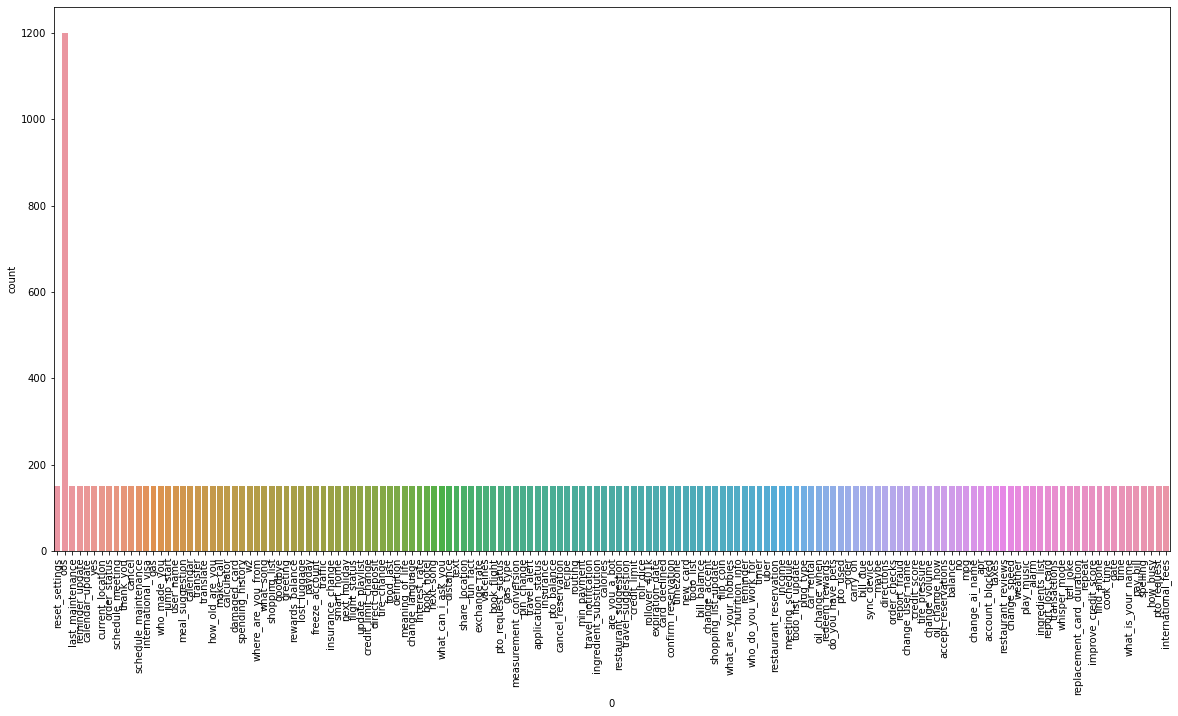

In [155]:
plt.figure(figsize=(20,10))
sns.countplot(x=labels_df[0], data=labels_df)
plt.xticks(rotation=90)
plt.show()

# 3. Splitting the dataset

In [45]:
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.3)

# 4.Preprocessing data after splitting to avoid data leakage

- Tokenization
- padding
- Label Encoding
- Word Embeddings (using GLOVE vectors)

In [46]:
max_num_words = 40000
classes = np.unique(labels)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index

In [47]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen,padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [48]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [49]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [50]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

C:\Users\snake\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# 5. Model Bulidng

In [51]:
model = Sequential()
model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [54]:
%%time
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=(test_sequences, test_labels))

Epoch 1/20
260/260 [==============================] - 203s 782ms/step - loss: 1.9727 - acc: 0.4488 - val_loss: 1.3473 - val_acc: 0.6235
Epoch 2/20
260/260 [==============================] - 207s 795ms/step - loss: 1.4346 - acc: 0.5892 - val_loss: 1.0296 - val_acc: 0.7204
Epoch 3/20
260/260 [==============================] - 206s 792ms/step - loss: 1.1154 - acc: 0.6810 - val_loss: 0.8283 - val_acc: 0.7693
Epoch 4/20
260/260 [==============================] - 210s 807ms/step - loss: 0.8897 - acc: 0.7459 - val_loss: 0.7302 - val_acc: 0.8001
Epoch 5/20
260/260 [==============================] - 203s 779ms/step - loss: 0.7852 - acc: 0.7789 - val_loss: 0.6589 - val_acc: 0.8217
Epoch 6/20
260/260 [==============================] - 195s 748ms/step - loss: 0.6644 - acc: 0.8166 - val_loss: 0.6182 - val_acc: 0.8354
Epoch 7/20
260/260 [==============================] - 203s 781ms/step - loss: 0.5661 - acc: 0.8423 - val_loss: 0.6150 - val_acc: 0.8394
Epoch 8/20
260/260 [============================

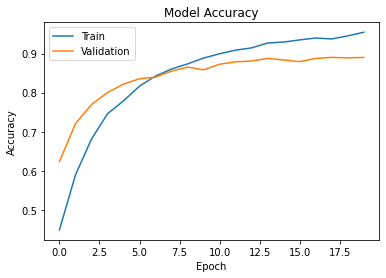

In [55]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

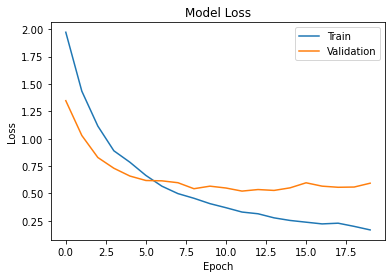

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Conclusion: Our model's validation accuracy and loss are good enough.

# 6. Saving and loading model

In [59]:
model.save('models/intents.h5')

with open('utils/classes.pkl','wb') as file:
    pickle.dump(classes,file)

with open('utils/tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer,file)

with open('utils/label_encoder.pkl','wb') as file:
    pickle.dump(label_encoder,file)

# 7. Creating class for automatic preprocessing and modeling of our new data

In [74]:
class IntentSentiClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        self.percentage = np.max(self.pred)
        
        
        print("Intent: ",label_encoder.inverse_transform(np.argmax(self.pred,1))[0],"with",np.round(self.percentage*100,2),"% accuracy")
        return

### Loading save models

In [4]:
model = load_model('models/intents.h5')

with open('utils/classes.pkl','rb') as file:
    classes = pickle.load(file)

with open('utils/tokenizer.pkl','rb') as file:
    tokenizer = pickle.load(file)

with open('utils/label_encoder.pkl','rb') as file:
    label_encoder = pickle.load(file)

# 8. Predicting Intent and sentiment of the query sentences 

In [75]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
model_obj = IntentSentiClassifier(classes,model,tokenizer,label_encoder)


Intent:  shopping_list with 58.24 % accuracy


In [78]:
sentence = "I love to buy dresses from mall"
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
model_obj.get_intent(sentence1)
print("Sentiment: ",total_sentiment)

Intent:  shopping_list with 58.24 % accuracy
Sentiment:  [POSITIVE (0.9951)]


In [82]:
sentence = "I dont like rajisthan's hot temperature"
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
model_obj2.get_intent(sentence)
print("Sentiment: ",total_sentiment)

Intent:  weather with 99.44 % accuracy
Sentiment:  [NEGATIVE (0.9999)]


In [83]:
sentence = "I would like to go andaman and nicobar islands"
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
model_obj2.get_intent(sentence)
print("Sentiment: ",total_sentiment)

Intent:  travel_alert with 93.57 % accuracy
Sentiment:  [POSITIVE (0.9544)]


In [85]:
sentence = "His sister is paralyzed after accident"
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
model_obj2.get_intent(sentence)
print("Sentiment: ",total_sentiment)

Intent:  oos with 42.61 % accuracy
Sentiment:  [NEGATIVE (0.9946)]


In [88]:
sentence = "Too much cheese is not good for health"
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
model_obj2.get_intent(sentence)
print("Sentiment: ",total_sentiment)

Intent:  nutrition_info with 99.94 % accuracy
Sentiment:  [NEGATIVE (0.9999)]


In [92]:
sentence = "tommorow you have meeting at 9 am"
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
model_obj2.get_intent(sentence)
print("Sentiment: ",total_sentiment)

Intent:  alarm with 98.54 % accuracy
Sentiment:  [POSITIVE (0.6705)]
